## Introduction to Recurrent Neural Networks


In our first challenge, we created a model that predicted labels from raw pixels, generating a high-level understanding of what the image represents. In this section we'll create a model that predicts the next word of a sentence from previous words, generating an understanding of language.

We exposed a network that was designed to learn the difference between images to a dataset full of labeled images. Here, we'll expose a network that is designed to learn about the structure of language to a **corpus** of text.

After this notebook, we'll have one [model](#model \"a trained network\") that understands images and another that understands language. We'll combine them to generate captions from images and video. 

Let's learn how to teach a neural network about language. We'll start with a small example using a tiny subset of the English language and a small corpus comprised of two sentences which will represent everything our network will know about language.

First, our dictionary (Click the cell below and press Shift and Enter to execute the code):

In [1]:
small_dict=['EOS','a','my','sleeps','on','dog','cat','the','bed','floor'] #'EOS' means end of sentence.

Next, we can create our small corpus that our network can use to learn about language. Let's create a few sentences from the words in our dictionary. The first vector in the numpy array 'X' represents the sentence ['my','cat','sleeps','on','my','bed', 'EOS']. Use that as a model to replace the ##FIXME## vector with the sentence, ['a', 'dog', 'sleeps', 'on', 'the', 'floor', 'EOS']. Hover [here](#hint "The second line should be X=np.array([[2,6,3,4,2,8,0],[1,5,3,4,7,9,0]],dtype=np.int32)") for a hint.

### <font color='blue'>Representing these words by their indices in the model</font>

In [2]:
import numpy as np #numpy is "numerical python" and is used in deep learning mostly for its n-dimensional array
X=np.array([[2,6,3,4,2,8,0],[1,5,3,4,7,9,0]],dtype=np.int32) 
print([small_dict[ind] for ind in X[0,:]]) # Can switch 1 and 0 on this line to switch between vectors

['my', 'cat', 'sleeps', 'on', 'my', 'bed', 'EOS']


Now that we have the data, we need to structure it for our network. Words are fundamentally different types of data from images. A 28X28 grayscale *image* is viewed as a 28X28 matrix where each cell represents the "grayness" of that pixel. A 256X256 color image is viewed as a 256X256X3 [tensor](#tensor "a vector, matrix, or any other "block" of n-dimensional data) where each cell contains the "redness," "greenness," and "blueness" at each pixel.

When classifying images, we used TensorFlow (or any other framework) to describe how that input tensor flows to a vector of probabilities. 

Words must also be converted into tensors before we can use them as our input. For this example, we'll use "one-hot-encoding," where each word will be represented by a vector with one '1' and the rest 0s. The vectors will be the length of the dictionary to have a '1' in a unique place depending on the word.

![](one-hot.PNG)

To see what we mean, let's run a TensorFlow [session](#sess \"where computational graphs described in TensorFlow are run\") to transform our input data to one-hot encoding and visualize what that looks like. Tensorflow's embedding_lookup and unstack functions make it easy to do this. For one-hot encoding, we can pass embedding_lookup an [identity matrix](#idmat "A matrix with ones in the diagonal and zeros everywhere else") the length of our dictionary and our input dataset. This could be done as part of a training session, but we've seperated it here to visualize our inputs. 

As a reminder of how small a subset of the English language we're using, replace ##FIXME## with the length of our dictionary. Hover [here](#dict_length "Replace ##FIXME## in np.identity with len(small_dict).") for a hint.

### <font color='blue'> One-hot encoding represents each word by a 1 in a unique place depending on the word </font>

In [3]:
import tensorflow as tf
from tensorflow.python.framework import ops

tf.reset_default_graph()
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    


with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        # defining the dimensions of the NP identity matrix
        result=tf.nn.embedding_lookup(np.identity(len(small_dict)), X).eval()
        example_input=sess.run([tf.unstack(result,X.shape[1],1)])
        coord.request_stop()
        coord.join(threads)
        sess.close()
print('one-hot encoded inputs')
print(result)
print('shape of the input')
print(result.shape)
print('reshaped input for training')
print(example_input)

one-hot encoded inputs
[[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]]
shape of the input
(2, 7, 10)
reshaped input for training
[[array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]), array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]]), array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]

### <font color='blue'> Using the identity matrix to find the relevant inputs </font>

We have our data! 

Recall that neural networks start out as randomized values. Through exposure to data, networks "learn" to create accurate mappings from inputs to outputs. 

Our image classification network output label predictions from image inputs. Our language processing network will output *next word* predictions from input of previous words. 

For example, let's take a sentence and attempt to do this ourselves (try not to look ahead):

Our sentence starts with the word: "My"

Using the dictionary of all the words you know, and the patterns that you have observed throughout your life, what word might come after the word "My"?

Great, now that you've guessed, you find out that the second word is "friend".

You learn a bit more about this sentence, and can use the first TWO words to guess the third. 

Next, you learn the third word is "went", you take that error and guess again. Do you know more about the structure of this sentence than you did at the beginning? If this were the first or thousandth sentence you've seen, you likely also know more about the structure of *all* sentences.

This is one way networks learn about language. This type of network is called a **recurrent neural network (RNN)**. They can learn all kinds of conventions: how "subjects" are related to "verbs," when punctuation usually occurs, etc, if they have enough time and a large enough dataset. They learn by reducing the error between their predicted next word and the actual next word in a corpus. RNNs are structured to "remember" the words that led to their prediction. 

Using the simplest RNN that we can, with only one layer, let's see what we can learn from our two sentences about the relationship between our 8 words.

### <font color='blue'> Training the neural network to predict the next word </font>

In [4]:
plot_loss=[]
num_hidden=24
num_steps=X.shape[1]
dict_length=len(small_dict)
batch_size=2
tf.reset_default_graph()

## Make Variables
variables_dict = {
    "weights1":tf.Variable(tf.truncated_normal([num_hidden,dict_length],stddev=1.0,dtype=tf.float32),name="weights1"),
    "biases1": tf.Variable(tf.truncated_normal([dict_length],stddev=1.0,dtype=tf.float32), name="biases1")}

# Create input data
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), X) #[batch,num_steps,dictionary_length][2,6,7]
y=np.zeros((batch_size,num_steps),dtype=np.int32)
y[:,:-1]=X[:,1:]
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), y),num_steps,1) #[batch,num_steps,dictionary_length][2,6,7]

y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])

#Create our LSTM
cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)

outputs, last_states = tf.contrib.rnn.static_rnn(
    cell=cell,
    dtype=tf.float32,
    inputs=tf.unstack(tf.to_float(X_one_hot),num_steps,1))

output_reshape=tf.reshape(outputs, [batch_size*num_steps,num_hidden]) #[12==batch_size*num_steps,num_hidden==12]
pred=tf.matmul(output_reshape, variables_dict["weights1"]) +variables_dict["biases1"]
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

In [6]:
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    

plot_loss=[]

with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)        
        for i in range(10):
            loss,_,y_target,y_pred,output=sess.run([cost,optimizer,y_target_reshape,pred,outputs])
            plot_loss.append([loss])

            if i% 5 ==0:
                print("iteration: ",i," loss: ",loss)
                
        print(y_target)
        print(np.argmax(y_pred,1))          
        coord.request_stop()
        coord.join(threads)
        sess.close()    

('iteration: ', 0, ' loss: ', 2.6325929)
('iteration: ', 5, ' loss: ', 1.9444559)
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[5 5 0 0 0 0 0 0 0 0 0 0 0 0]


Our RNN has seen our 2 sentences 10 times. Each time it has seen a new word, it has attempted to predict the next word. TensorFlow is reporting a "loss" or error in those predictions of ~2.15. Let's see what this looks like with a sample sentence.

In [8]:
#Lets look at one input data point at each step and its prediction
print("Input Sentence")
sn=0 #The sentence number
print([small_dict[ind] for ind in X[sn,:]])
print("Predicted words")
print([small_dict[ind] for ind in np.argmax(y_pred[sn::2],1)])

Input Sentence
['my', 'cat', 'sleeps', 'on', 'my', 'bed', 'EOS']
Predicted words
['dog', 'EOS', 'EOS', 'EOS', 'EOS', 'EOS', 'EOS']


Can we at least predict the sentences used for training?  By passing the first word of the sentence to the predictor, the result should be our original sentence.  What happened?

Try raising the number of iterations in the code block above to 300.  How does this affect the ability of the network to predict the original sentences?

While we're able to perfectly predict sentences in our small sample, we're going to take on more complex examples next. Let's peek at some levers that we have that can affect performance: the depth of the network and an operation called "dropout." 

Deeper models have the ability to represent more complex functions. To build a deeper model in TensorFlow, we can just create our layers in a loop.

Let's train an RNN with 2 and 4 layers. What parameter do you need to set to change the number of layers in your RNN? For a hint hover [here](#answer1 "num_layers=2 or num_layer=4. This is used in the 'for' loop where lstm_cells are created").

Dropout increases your model's ability to generalize by actually asking it to "forget" some parameters as it trains. To see where you adjust dropout values, hover [here](#answer2 "dropout = ___, where 1.0 = none -remember everything and 0.0 = all -remember nothing". This is implemented here: lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,input_keep_prob=dropout,output_keep_prob=dropout)"). 

Experiment with the two to see if you can increase performance.                       

In [9]:
#Now let's try multiple layers 
plot_loss2=[]
num_hidden=24
num_steps=X.shape[1]
dict_length=len(small_dict)
batch_size=2
num_layers= 2
tf.reset_default_graph()

## Make Variables
# Initialize the Weights and Biases with a truncated normal distribution
variables_dict = {
    "weights1":tf.Variable(tf.truncated_normal([num_hidden,dict_length],stddev=1.0,dtype=tf.float32),name="weights1"),
    "biases1": tf.Variable(tf.truncated_normal([dict_length],stddev=1.0,dtype=tf.float32), name="biases1")}

# Create input data - A representation of input data using data lookup
#small_dict=['EOS','i','will','walk','the','dog','cat','run']
#X=np.array([[1,2,7,4,5,0],[1,2,3,4,6,0]],dtype=np.int32)  
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), X) 
y=np.zeros((batch_size,num_steps),dtype=np.int32)
y[:,:-1]=X[:,1:]
# Unstack unranks the tensor down by one rank
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), y),num_steps,1) 
y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])
dropout = 1

##################### Create a multilayer RNN ####################
layer_cell=[]
for _ in range(num_layers):
    # Here initialize the LSTM Cell
    lstm_cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)
    lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,
                                          input_keep_prob=dropout,
                                          output_keep_prob=dropout)
    layer_cell.append(lstm_cell)

cell = tf.contrib.rnn.MultiRNNCell(layer_cell, state_is_tuple=True)
outputs, last_states = tf.contrib.rnn.static_rnn(
    cell=cell,
    dtype=tf.float32,
    inputs=tf.unstack(tf.to_float(X_one_hot),num_steps,1))

# reshape allows the reshaping of a tensor so that any matrix multiplication can be performed
output_reshape=tf.reshape(outputs, [batch_size*num_steps,num_hidden])
pred=tf.matmul(output_reshape, variables_dict["weights1"]) +variables_dict["biases1"]

# reduce_mean on the logits
# logits are raw class scores, in this case the score of what the next word should be
# The network outputs a score for each word
# Softmax is how you turn scores into probabilities
    # Essentially normalizes the class scores so that they add up to one, and therefore probabilities
# Cross entropy measures the difference between the ground truth labels and the softmax values
# And then take the reduce_mean
    # Get the difference between probabilities of the softmax  and ground truth, then take the mean of that to provide
    # the next word
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

# Now Data Analysis heavily involves the tuning of hyper parameters like LSTM layers and such
# Bayesian Optimization

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    


with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        for i in range(300):
            loss,_,y_target,y_pred,output=sess.run([cost,optimizer,y_target_reshape,pred,outputs])
            plot_loss2.append([loss])
            
            if i% 25 ==0:
                print("iteration: ",i," loss: ",loss)
                
        print(y_target)
        print(np.argmax(y_pred,1))         
        coord.request_stop()
        coord.join(threads)
        sess.close()    


('iteration: ', 0, ' loss: ', 2.5742502)
('iteration: ', 25, ' loss: ', 0.83553731)
('iteration: ', 50, ' loss: ', 0.12750596)
('iteration: ', 75, ' loss: ', 0.014045434)
('iteration: ', 100, ' loss: ', 0.0049265632)
('iteration: ', 125, ' loss: ', 0.0031215425)
('iteration: ', 150, ' loss: ', 0.0022784797)
('iteration: ', 175, ' loss: ', 0.0017514136)
('iteration: ', 200, ' loss: ', 0.0014063881)
('iteration: ', 225, ' loss: ', 0.0011645798)
('iteration: ', 250, ' loss: ', 0.00098588294)
('iteration: ', 275, ' loss: ', 0.0008488117)
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0. 

### <font color='blue'> Because RNNs are universal function approximators, they can be applied to almost any function. You don't want to have an approximation that completely fits the data, so add DROPOUTs to prevent Overfit. If running a linear regression model, another method would be to penalize over-weighted factors. By adding dropouts, you prevent the neural network from overdepending on a particular pathway. Bigger models are now possible with these types of batch normalization and regularization techniques</font>

# Compare the loss from our single and multi-layer RNN. 

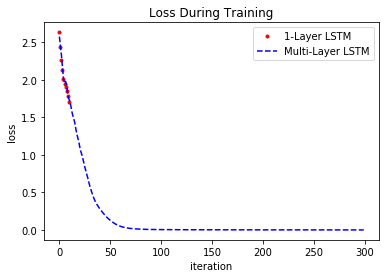

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(plot_loss,'r.')
plt.plot(plot_loss2,'b--')
plt.legend(["1-Layer LSTM","Multi-Layer LSTM"])
plt.ylabel("loss")
plt.xlabel("iteration")
plt.title("Loss During Training")
plt.show()

Our model can complete these two sentences well, but knows nothing about the rest of language. (It's like we learned two lines of a song.) If, instead, we were working to build an understanding of language in general, we'd be heavily **overfitting** to our corpus. Increasing the complexity (depth) of our model can learn about more complex [corpuses](#corpora "actually corpora") but can cause overfitting. Dropout is one method for reducting overfitting. Let's keep these strategies in mind as we work to learn about an entire type of language, the caption. 

### Train an RNN with MSCOCO Captions 
Now we are going to use the [Microsoft Common Objects in Context](http://mscoco.org/) (MSCOCO) image captions to train an RNN to understand captions. The cell below shows one way to read, format, and feed the data into TensorFlow. First, we will read the caption file, then we will remove the punctuation, and then train. Due to time constraints, we won't use the full dataset for this training. However, it would be easy to change this and train with more or the entire dataset. Can you see an easy way to do this?

In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import inspect
import time

from tensorflow.python.framework import dtypes
#import reader
import collections
import os
import re
import json

num_steps=20
## Read Training files
with open("/data/mscoco/captions_train2014.json") as data_file:
         data=json.load(data_file)

TotalNumberofCaptions=len(data['annotations'])

sentences=[]

##Create a list of all of the sentences.
for i in range(TotalNumberofCaptions):
        sentences+=[re.sub('[^A-Za-z0-9]+',' ',data['annotations'][i]['caption']).lower()]

TotalWordList=[]
for i in range(TotalNumberofCaptions):
        TotalWordList+=re.sub('[^A-Za-z0-9]+',' ',data['annotations'][i]['caption']).lower().split()

#Determine number of distinct words 
distinctwords=collections.Counter(TotalWordList)
#Order words 
count_pairs = sorted(distinctwords.items(), key=lambda x: (-x[1], x[0])) #ascending order
words, occurence = list(zip(*count_pairs))
DictionaryLength=occurence.index(4) #index for words that occur 4 times or less
words=['PAD','UNK','EOS']+list(words[:DictionaryLength])
word_to_id=dict(zip(words, range(len(words))))
#Tokenize Sentence
Tokenized=[]
for full_words in sentences:
        EmbeddedSentence=[word_to_id[word] for word in full_words.split() if word in word_to_id]+[word_to_id['EOS']]
        #Pad sentences that are shorter than the number of steps 
        if len(EmbeddedSentence)<num_steps:
            b=[word_to_id['PAD']]*num_steps
            b[:len(EmbeddedSentence)]=EmbeddedSentence
        if len(EmbeddedSentence)>num_steps:
            b=EmbeddedSentence[:num_steps]
        if len(b)==EmbeddedSentence:
            b=EmeddedSentence
        b=[word_to_id['UNK'] if x>=DictionaryLength else x for x in b] #turn all words used 4 times or less to 'UNK'
        #print(b)
        Tokenized+=[b]

We can see that we take these captions and "tokenize" them, or convert each word into a number (in descending order based on popularity). We also have a variety of sentence lengths, so in order to create a standard input and output tensor, we've padded short sentence with 0s and truncated long sentences. 

In [12]:
############################################# Parameters #####################################################

num_hidden=256
num_steps=20
dict_length=len(words)
batch_size=4


## Create labels
Label=[]
for caption in Tokenized:
    Label+=[caption[1:]+[word_to_id['PAD']]]

NumberofCasestoEvaluate=20
TrainingInputs=Tokenized[:NumberofCasestoEvaluate]
LabelInputs=Label[:NumberofCasestoEvaluate]

#Print out some variables 
print(TrainingInputs[0])
print(LabelInputs[0])
print("Number of words in this dictionary", len(words))

[3, 142, 508, 9, 619, 415, 276, 57, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[142, 508, 9, 619, 415, 276, 57, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of words in this dictionary 8768


You can see two things:

1. Our [labels](#labels "labels are the outputs that we want our network to generate") are the next *token* in our training set.
2. This dictionary is much bigger. 

We'll feed our data to our network in batches of 4 to take further advantage of parallel processing and the GPU in training time. 

In [13]:
#Create our input queue
def data_input_queue(TrainingInputs, LabelInputs, num_steps):
    train_input_queue = tf.train.slice_input_producer(
                                    [TrainingInputs, LabelInputs],
                                    shuffle=True)

    ##Set our train data and label input shape for the queue
    TrainingInput=train_input_queue[0]
    LabelInput=train_input_queue[1]
    TrainingInput.set_shape([num_steps])
    LabelInput.set_shape([num_steps])
    min_after_dequeue=100000
    capacity = min_after_dequeue + 3 * batch_size 
    #input_x, target_y
    train_x, train_y = tf.train.batch([TrainingInput, LabelInput],
                                                 batch_size=batch_size ,
                                                 capacity=capacity,
                                                 num_threads=4)
    return train_x, train_y

Now you are ready to train an RNN with the MSCOCO captions. Feel free to experiment with number of layers and dropout again.

In [14]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
num_layers=4
dropout = 0.5

loss_mscoco=[]
#######################################################################################################
TrainingInputs=Tokenized[:NumberofCasestoEvaluate]
LabelInputs=Label[:NumberofCasestoEvaluate]


variables_dict = {
    "weights_mscoco":tf.Variable(tf.truncated_normal([num_hidden,dict_length],
                                                     stddev=1.0,dtype=tf.float32),name="weights_mscoco"),
    "biases_mscoco": tf.Variable(tf.truncated_normal([dict_length],
                                                     stddev=1.0,dtype=tf.float32), name="biases_mscoco")}


# Create input data
train_x, train_y =data_input_queue(TrainingInputs, LabelInputs, num_steps)
mscoco_dict=words
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), train_x) #[batch,num_steps,dictionary_length]
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), train_y),num_steps,1)#[batch,num_steps,dictionary_length]
y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])

input_keep_prob=dropout
output_keep_prob=dropout

#Create a multilayer RNN

layer_cell=[]
for _ in range(num_layers):
    lstm_cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)
    ############# add dropout #########################
    lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,
                                          input_keep_prob=dropout,
                                          output_keep_prob=dropout)
    layer_cell.append(lstm_cell)

cell = tf.contrib.rnn.MultiRNNCell(layer_cell, state_is_tuple=True)
outputs, last_states = tf.contrib.rnn.static_rnn(
    cell=lstm_cell,
    dtype=tf.float32,
    inputs=tf.unstack(tf.to_float(X_one_hot),num_steps,1))

output_reshape=tf.reshape(outputs, [batch_size*num_steps,num_hidden])
pred=tf.matmul(output_reshape, variables_dict["weights_mscoco"]) +variables_dict["biases_mscoco"]
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost,aggregation_method = tf.AggregationMethod.EXPERIMENTAL_TREE)


init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    


with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        for i in range(1500):
            x_input,y_input=sess.run([train_x, train_y])
            loss,_,y_target,x_input,y_input,y_pred=sess.run([cost,optimizer,y_target_reshape,train_x, train_y,pred])
            loss_mscoco.append([loss])
            if i% 100==0:
                print("iteration: ",i, "loss: ",loss)  
        print("Done Training")
        coord.request_stop()
        coord.join(threads)
        sess.close()    

iteration:  0 loss:  9.71161
iteration:  100 loss:  1.29671
iteration:  200 loss:  0.49167
iteration:  300 loss:  0.349732
iteration:  400 loss:  0.301553
iteration:  500 loss:  0.55129
iteration:  600 loss:  0.149387
iteration:  700 loss:  0.101614
iteration:  800 loss:  0.379505
iteration:  900 loss:  0.295773
iteration:  1000 loss:  0.329667
iteration:  1100 loss:  0.228802
iteration:  1200 loss:  0.256149
iteration:  1300 loss:  0.890074
iteration:  1400 loss:  0.419619
Done Training


In [15]:
#Lets look at one input data point and its prediction
print("Input Sentence")
batch_element=2
print([words[ind] for ind in x_input[batch_element,:]])
print("Target")
print([words[ind] for ind in y_input[batch_element,:]])
print("Predicted words")
print([words[ind] for ind in np.argmax(y_pred[batch_element::batch_size],1)])

Input Sentence
[u'a', u'white', u'square', u'kitchen', u'with', u'tile', u'floor', u'that', u'needs', u'repairs', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Target
[u'white', u'square', u'kitchen', u'with', u'tile', u'floor', u'that', u'needs', u'repairs', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Predicted words
[u'panoramic', u'square', u'kitchen', u'with', u'tile', u'floor', u'that', u'needs', u'repairs', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']


How'd we do? We've learned to use RNNs to predict next words from previous words and our RNN's understanding of language. 

What kind of problems could we solve by deploying this model?

If we built the skills to do this really well, we could do interesting things like start to mimic someone's style of writing, generate stock market quote predictions based on past performance, or suggest next words in text messages.

We're limited by the fact that the [ground truth](#gt "actual next word at every timestep") is being propogated through the network. If we were to generate more than just a single word, our performance would be dismal. In the next section, we're going to provide our network with a muse, something to write about, in the form of an image. 

We're going to combine our CNN's high-level understanding of the image AND our RNN's understanding of captions to generate captions from images.

In [ ]:
#Free our GPU memory before proceeding to the next part of the lab - you'll get a warning indicating "Kernal is dead." That's to be expected. 
import os
os._exit(00)

## References 
[1] Imanol Schlab. TensorFLow Input Pipeline Example. http://ischlag.github.io/2016/06/19/tensorflow-input-pipeline-example/

[2] Denny Britz. Practical Examples for RNNs in TensorFlow https://github.com/dennybritz/tf-rnn

[3]Lin, Tsung-Yi, et al. "Microsoft coco: Common objects in context." European Conference on Computer Vision. Springer International Publishing, 2014.